In [11]:
import numpy as np
import torch as th
import torch as th
import pandas as pd
import os, glob, sys, tqdm
from collections import defaultdict
from PIL import Image

def sh_to_ld(sh):
    #NOTE: Roughly Convert the SH to light direction
    sh = sh.reshape(-1, 9, 3)
    ld = th.mean(sh[0:1, 1:4, :], dim=2)
    return ld

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

def load_deca_params(deca_dir, cfg):
    deca_params = {}

    # face params 
    params_key = ['shape', 'pose', 'exp', 'cam', 'light', 'faceemb', 'shadow', 'albedo', 'detail']
    for k in tqdm.tqdm(params_key, desc="Loading deca params..."):
        params_path = glob.glob(f"{deca_dir}/*{k}-anno.txt")
        for path in params_path:
            deca_params[k] = read_params(path=path)
    
    deca_params = swap_key(deca_params)
    return deca_params

def create_image_grid(images, n_rows=1):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)
    return grid_image

In [2]:
pth = '/data/mint/DPM_Dataset/ffhq_256_with_anno/params/'
set_ = 'valid'

In [26]:
sys.path.append('/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/')
import params_utils
params = load_deca_params(deca_dir=f'{pth}/{set_}/', cfg=None)
mask = params_utils.load_flame_mask(['face'])
deca_obj = params_utils.init_deca(mask=mask)


img_name = '60065.jpg'
src_idx = 0
cond = {}
for k in params[img_name].keys():
    cond[k] = params[img_name][k][None, ]

for k in cond.keys():
    cond[k] = th.tensor(cond[k]).cuda()
    print(k, cond[k].shape)

cond['raw_image_path'] = [f'/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/{img_name}']
cond['raw_image'] = th.tensor(np.array(Image.open(cond['raw_image_path'][0]))).cuda().permute(2, 0, 1).float().unsqueeze(0)/255.0
deca_rendered, orig_visdict = params_utils.render_deca(deca_params=cond, 
                                                    idx=src_idx, n=1, 
                                                    avg_dict=None, 
                                                    render_mode='shape', 
                                                    rotate_normals=False, 
                                                    mask=mask,
                                                    deca_obj=deca_obj,
                                                    repeat=True)


Loading deca params...: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


creating the FLAME Decoder
[#] DECA : SRenderY applied mask
shape torch.Size([1, 100])
pose torch.Size([1, 6])
exp torch.Size([1, 50])
cam torch.Size([1, 3])
light torch.Size([1, 27])
faceemb torch.Size([1, 512])
shadow torch.Size([1, 1])
albedo torch.Size([1, 50])
detail torch.Size([1, 128])
1 1


/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/params_utils.py:243: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'light':th.tensor(deca_params['light']).to(device).reshape(-1, 9, 3).float(),


[#] There's 1 faces detected, using face 0
[#] There's 1 faces detected, using face 0


/tmp/ipykernel_2259297/784778737.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ld = sh_to_ld(sh=th.tensor(sh_light[[i]])).cuda()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ray:  tensor([ 0.4794, -0.7500,  0.4556], device='cuda:0', dtype=torch.float64) torch.Size([3])
Normalized with mxaxis = 0.750031248656316:  tensor([ 0.6392, -1.0000,  0.6075], device='cuda:0', dtype=torch.float64)
Shift:  torch.Size([256, 3])
tensor(162.9949, device='cuda:0', dtype=torch.float64) tensor(0., device='cuda:0', dtype=torch.float64)
tensor(-0., device='cuda:0', dtype=torch.float64) tensor(-255., device='cuda:0', dtype=torch.float64)
tensor(154.9129, device='cuda:0', dtype=torch.float64) tensor(0., device='cuda:0', dtype=torch.float64)
Depth:  tensor(255.9161, device='cuda:0', dtype=torch.float64) tensor(0., device='cuda:0', dtype=torch.float64)
Coords:  tensor(410.8291, device='cuda:0', dtype=torch.float64) tensor(0., device='cuda:0', dtype=torch.float64)
Output:  torch.Size([256, 1, 256, 256])
Diff:  torch.Size([256, 256, 256])
tensor(255.9161, device='cuda:0', dtype=torch.float64) tensor(0., device='cuda:0', dtype=torch.float64)


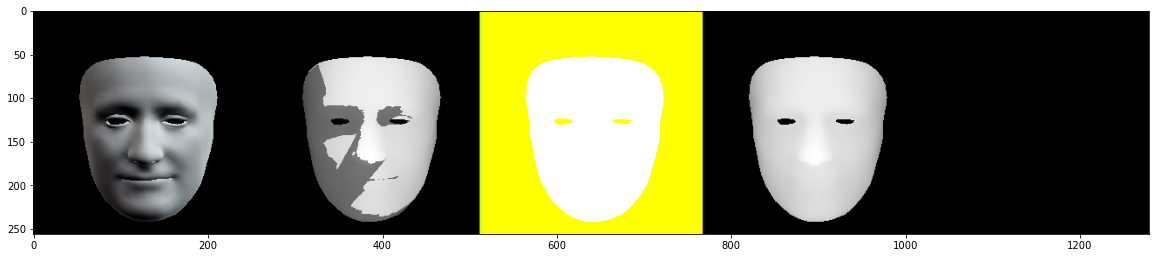

In [204]:
def render_shadow_mask(sh_light, cam, verts, deca):
    sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
    from decalib.utils import util
    
    shadow_mask_all = []
    if verts.shape[0] >= 2:
        tmp = []
        for i in range(1, verts.shape[0]):
            tmp.append(th.allclose(verts[[0]], verts[[i]]))
        assert all(tmp)
        
    depth_image, alpha_image = deca.render.render_depth(verts.cuda())   # Depth : B x 1 x H x W
    _, _, h, w = depth_image.shape
    depth_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
    # print(depth_grid[0].shape, depth_grid[1].shape)
    depth_grid = np.repeat(np.stack((depth_grid), axis=-1)[None, ...], repeats=sh_light.shape[0], axis=0)   # B x H x W x 2
    # print(depth_grid.shape)
    depth_grid = np.concatenate((depth_grid, depth_image.permute(0, 2, 3, 1)[..., 0:1].cpu().numpy()), axis=-1) # B x H x W x 3
    # print(depth_grid.shape)
    depth_grid[..., 2] *= 256
    depth_grid = th.tensor(depth_grid).cuda()
    shadow_mask = th.clone(depth_grid[:, :, :, 2])  # Clone the depth image to get the shadow mask
    # print(shadow_mask.shape, sh_light.shape)
    for i in range(sh_light.shape[0]):
        each_depth_grid = depth_grid[i].clone()
        #NOTE: Render the shadow mask from light direction
        ld = sh_to_ld(sh=th.tensor(sh_light[[i]])).cuda()
        # ld[..., 1:] = -ld[..., 1:]
        ld = util.batch_orth_proj(ld[None, ...], cam[None, ...].cuda()) # Project the light direction to the camera space (# This fn takes pts=Bx3, cam=Bx3)
        # ld_x is left-right, ld_y is up-down, ld_z is front-back
        ld[:,:,1:] = -ld[:,:,1:]
        # ld[:,:,0:1] = -ld[:,:,0:1]
        # ld[:,:,1:2] = -ld[:,:,1:2]
        # ld[:,:,2:3] = -ld[:,:,2:3]
        ray = ld.view(3).cuda()
        ray[2] *= 0.5
        n = 256
        ray = ray / th.norm(ray)    # Normalize the ray
        print("Ray: ", ray, ray.shape)
        mxaxis = max(abs(ray[0]), abs(ray[1]))
        print(f"Normalized with mxaxis = {mxaxis}: ", ray/mxaxis)
        shift = ray / mxaxis * th.arange(n).view(n, 1).cuda()   # Aligning the ray with the grid
        print("Shift: ", shift.shape)
        print(th.max(shift[..., 0]), th.min(shift[..., 0]))
        print(th.max(shift[..., 1]), th.min(shift[..., 1]))
        print(th.max(shift[..., 2]), th.min(shift[..., 2]))
        coords = each_depth_grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)# * 0.01
        print("Depth: ", th.max(each_depth_grid[:, :, 2]), th.min(each_depth_grid[:, :, 2]))
        print("Coords: ", th.max(coords[..., 2]), th.min(coords[..., 2]))
        # print("Depth grid: ", each_depth_grid.shape)
        # print("Coords: ", coords.shape)
        # print(th.max(coords[..., :2]), th.min(coords[..., :2]))
        # print(th.max(coords[..., :2] / (n - 1) * 2 - 1), th.min(coords[..., :2] / (n - 1) * 2 - 1))
        # print("Each depth grid: ", th.max(each_depth_grid[:, :, 2]), th.min(each_depth_grid[:, :, 2]))

        # print("B4 Prep grid: ", each_depth_grid[:, :, 2].shape) # H x W
        # print("Af Prep grid: ", each_depth_grid[:, :, 2].view(1, 1, n, n).shape)    # 1 x 1 x H x W
        # print("Input to grid_sample: ", np.tile(each_depth_grid[:, :, 2].view(1, 1, n, n).cpu().numpy(), [n, 1, 1, 1]).shape)   # n x 1 x H x W
        output = th.nn.functional.grid_sample(
            input=th.tensor(np.tile(each_depth_grid[:, :, 2].view(1, 1, n, n).cpu().numpy(), [n, 1, 1, 1])).cuda(),
            grid=coords[..., :2] / (n - 1) * 2 - 1,
            align_corners=True)
        print("Output: ", output.shape)
        diff = coords[..., 2] - output[:, 0] 
        # diff = coords[..., 2] - each_depth_grid[..., 2][None, ...]
        print("Diff: ", diff.shape)
        shadow_mask[i] *= (th.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5
        print(th.max(shadow_mask[i]), th.min(shadow_mask[i]))
        
    return th.clip(shadow_mask, 0, 255.0)/255.0, depth_image, depth_grid, diff

shadow_mask, depth_image, depth_grid, diff = render_shadow_mask(
                sh_light=cond['light'], 
                cam=cond['cam'][src_idx],
                verts=orig_visdict['trans_verts_orig'], 
                deca=deca_obj)

import matplotlib.pyplot as plt
shadow_mask = shadow_mask.cpu().numpy().transpose(1, 2, 0)
shadow_mask = np.repeat(shadow_mask, 3, axis=-1)
depth_image = depth_image[0].cpu().numpy().transpose(1, 2, 0)
depth_image = np.repeat(depth_image, 3, axis=-1)
depth_grid = depth_grid[0].cpu().numpy()
deca_ren = deca_rendered[0].cpu().numpy().transpose(1, 2, 0)
diff = diff[0:1].cpu().numpy().transpose(1, 2, 0)
diff = np.repeat(diff, 3, axis=-1)

fig = plt.figure(figsize=(20, 10))
plt.imshow(create_image_grid([deca_ren, shadow_mask, depth_grid, depth_image, diff], n_rows=1))
plt.show()